In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from fem2D import Node, Element, plotMesh, readGmsh4, shapeFunctions, interp, readGLL, eraseCurrentMesh

Info    : Reading '../meshes/square4.msh'...
Info    : 9 entities
Info    : 625 nodes
Info    : 60 elements
Info    : Done reading '../meshes/square4.msh'


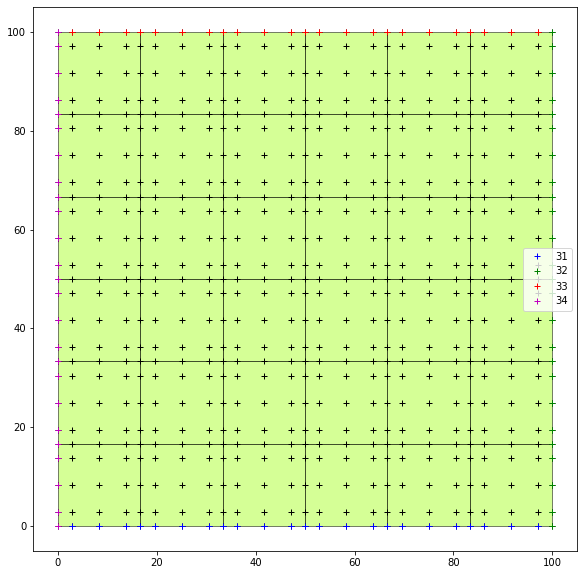

In [3]:
# chargement du maillage

eraseCurrentMesh()

file = "../meshes/square4.msh"
# file = "../meshes/octogon2.msh"


regions = [
    (1, 31),
    (1, 33),
    (1, 32),
    (1, 34),
    ]
elements, nodes = readGmsh4(file, regions) 
plotMesh(elements, nodes, [31, 32, 33, 34], allNodes=True) 
dof = len(nodes)

In [8]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

N = int(np.sqrt(len(elements[0].nodes))) - 1
xi,w,dh = readGLL(N)

print(f"{N=}")

N=4


In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

for e in elements:
    
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N,N))
    Je21 = np.zeros((N,N))
    Je12 = np.zeros((N,N))
    Je22 = np.zeros((N,N))
    
    e.detJ = np.zeros((N,N))
    
    e.IJe11 = np.zeros((N,N))
    e.IJe21 = np.zeros((N,N))
    e.IJe12 = np.zeros((N,N))
    e.IJe22 = np.zeros((N,N))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    for i in range(N):
        for j in range(N):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.IJe11[i,j] = Je22[i,j]/e.detJ[i,j]
            e.IJe22[i,j] = Je11[i,j]/e.detJ[i,j]
            e.IJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.IJe12[i,j] = -Je12[i,j]/e.detJ[i,j]

In [ ]:
for e in tqdm(elements):
    
    e.Ke = np.zeros(((N+1)**2,(N+1)**2))
    
    for i in range((N+1)**2):
        for j in range((N+1)**2):
                      
            fk = np.array([e.iJ[k]@dh2d[k//(N+1),k,:]@e.iJ[k]@dh2d[k-(N+1)*k//(N+1),k,:] for k in range((N+1)**2)])/e.detJ
            e.Ke[i,j] = int2D(fk)